In [1]:
from graph_tool.all import *
import graph_tool.all as gt
import numpy.random as rnd
import numpy as np
import time
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import pandas as pd

In [2]:
S = 0
I = 1
R = -1

T = 0.3
r = 0.1

max_itr = 200

# 何回で平均をとるのか？
num_iterations = 100

In [3]:
number_of_node = 1000
number_of_new_link = 2
number_of_module = 10

In [4]:
def LT():
    # 全ノードをランダムに並べ替える
    vs = list(G.vertices())
    rnd.shuffle(vs)
    # 並べ替えたノードリストを走査し状態更新を行う
    for v in vs:
        if state[v] == S:
            # S状態のノードの隣接ノードを取得
            ns = list(v.out_neighbors())
            # 隣接ノードの中でI状態のノードの数をカウント
            num_infected_neighbors = sum(1 for n in ns if state[n] == I)
            # 隣接ノードが存在する場合、I状態のノードの割合を計算
            if len(ns) > 0:
                infected_ratio = num_infected_neighbors / len(ns)
                # 割合がT以上なら、状態をIに変更
                if infected_ratio >= T:
                    state[v] = I
        elif state[v] == I:
            # 状態がIの場合、確率rでR状態に変更
            if rnd.random() < r:
                state[v] = R
    return

In [5]:
def node_data_numpy(G):
    # ノードの情報を格納するNumPy配列を作成
    node_ids = np.array([int(G.vp.node_id[v]) for v in G.vertices()])
    module_numbers = np.array([int(G.vp.module_number[v]) for v in G.vertices()])

    # NumPy配列を結合して2次元の配列を作成
    numpy_array = np.column_stack((node_ids, module_numbers))

    return numpy_array

In [6]:
# 100個のグラフの状態の平均を格納するリスト
avg_suscept_st = []
avg_infect_st = []
avg_recov_st = []

for i in tqdm(range(num_iterations)):
    G = load_graph(
        f"~/yhayashi_result/my_code/create_module/"
        f"N={number_of_node}_L={number_of_new_link}_"
        f"M={number_of_module}/{i}.gt.gz"
    )
    # 状態初期化
    state = G.new_vertex_property("int")
    for v in G.vertices():
        state[v] = S     
    numpy_data = node_data_numpy(G)
    # Module_Numberが1のノードだけを抜き出す
    module_1_nodes = numpy_data[numpy_data[:, 1] == 1]
    # 取得したNode_ID（0に入っている）をリストに変換
    node_ids = module_1_nodes[:, 0].tolist()
    # ランダムに3つのノードを選択して状態をIに変更
    selected_node_ids = random.sample(node_ids, min(50, len(node_ids)))
    for v in selected_node_ids:
        state[v] = I
        
    suscept_st = []
    infect_st = []
    recov_st = []

    suscept_st.append(list(state.a).count(S))
    infect_st.append(list(state.a).count(I))
    recov_st.append(list(state.a).count(R))

    # シミュレーションの実行
    for updt in range(max_itr):
        LT()
        suscept_st.append(list(state.a).count(S))
        infect_st.append(list(state.a).count(I))
        recov_st.append(list(state.a).count(R))
        
    # グラフごとに状態を格納
    avg_suscept_st.append(suscept_st)
    avg_infect_st.append(infect_st)
    avg_recov_st.append(recov_st)

# 100個のグラフの平均を計算
avg_suscept_st = np.mean(np.array(avg_suscept_st), axis=0)
avg_infect_st = np.mean(np.array(avg_infect_st), axis=0)
avg_recov_st = np.mean(np.array(avg_recov_st), axis=0)

100%|█████████████████████████████████████████| 100/100 [03:54<00:00,  2.35s/it]


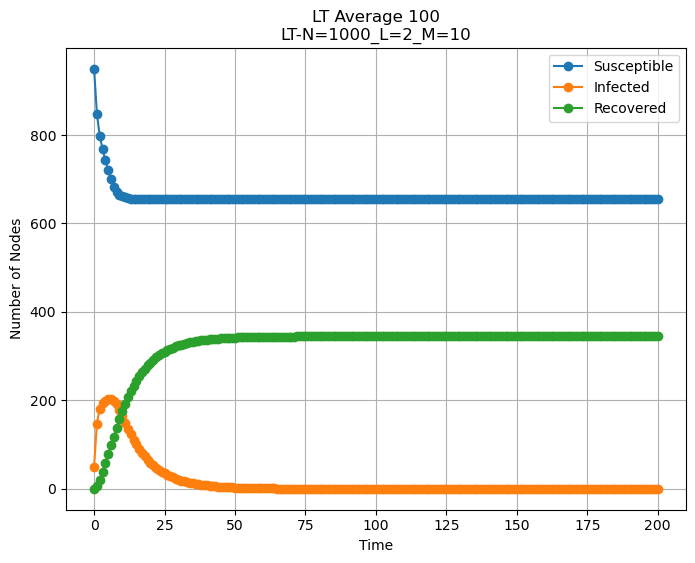

In [7]:
# プロット
plt.figure(figsize=(8, 6))
plt.plot(avg_suscept_st, label='Susceptible', marker='o')
plt.plot(avg_infect_st, label='Infected', marker='o')
plt.plot(avg_recov_st, label='Recovered', marker='o')
plt.xlabel('Time')
plt.ylabel('Number of Nodes')
# グラフの情報をもとにタイトルを作成
graph_info = f"N={number_of_node}_L={number_of_new_link}_M={number_of_module}"
title = f"LT-{graph_info}"
plt.title(f'LT Average 100\n{title}')
plt.legend()
plt.grid(True)
plt.show()